In [1]:
%load_ext autoreload
import sys
sys.path.append('../../..')
import numpy as np
from scipy.interpolate import interp1d, interp2d

import config
import main_components as main
import pickle
import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

no_boost = pickle.load(open(output_dir+'elec_swave_mDM2e8_nmax10_iter2_no_boost.p','rb'))
boost = pickle.load(open(output_dir+'elec_swave_mDM2e8_nmax10_iter2_boost.p','rb'))

# Generate data, if not loading previous

In [2]:
# CMB constraints on interaction rates
input_dir = config.data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [3]:
%autoreload

pri = 'elec'
DM_process = 'swave'
mDM = 2e8
param = param_bound(mDM, DM_process, pri)

nmax = 10
start_rs, end_rs = 3000, 4
cf = 16
rtol = 1e-6
iterations = 5

# no_boost = main.evolve(
#     DM_process=DM_process, mDM=mDM,
#     lifetime=param,
#     sigmav=param,
#     primary=pri+'_delta',
# #     struct_boost=phys.struct_boost_func(),
#     start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
#     reion_switch=True, reion_method='Puchwein', heat_switch=True,
#     coarsen_factor=cf, rtol=rtol,
#     distort=True, fexc_switch = True, 
#     reprocess_distortion=True, 
#     nmax=nmax, iterations=iterations
# )
# pickle.dump(no_boost, open(output_dir+'elec_swave_mDM2e8_nmax10_iter2_no_boost.p', 'wb'))

# boost = main.evolve(
#     DM_process=DM_process, mDM=mDM,
#     lifetime=param,
#     sigmav=param,
#     primary=pri+'_delta',
#     struct_boost=phys.struct_boost_func(),
#     start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
#     reion_switch=True, reion_method='Puchwein', heat_switch=True,
#     coarsen_factor=cf, rtol=rtol,
#     distort=True, fexc_switch = True, 
#     reprocess_distortion=True, 
#     nmax=nmax, iterations=iterations
# )
# pickle.dump(boost, open(output_dir+'elec_swave_mDM2e8_nmax10_iter2_boost.p', 'wb'))

# Get components

In [4]:
bICS_component = boost[-1]['lowengphot'].copy()
bICS_component._grid_vals *= list(map(int, bICS_component.eng < phys.rydberg))
bICS_component.redshift(1)
bICS = {'distortion': bICS_component.sum_specs()}

# Difference from structure formation

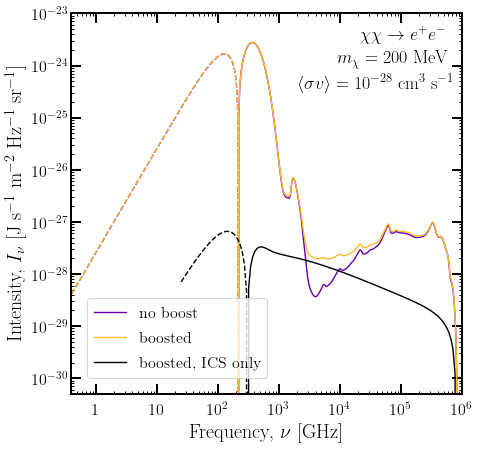

In [5]:
cmap = cm.plasma(np.linspace(0.2,0.85,2))

plt.figure(figsize=(7,7))
ax = plt.gca()

plot_distortion(ax, no_boost[-1], label=r'no boost',
                color=cmap[0], leg=True, first=False)
plot_distortion(ax, boost[-1], label=r'boosted',
                color=cmap[1], leg=True, first=False)
plot_distortion(ax, bICS, label=r'boosted, ICS only',
                color='k', leg=True, first=False)
plt.ylim(5e-31,1e-23)
plt.text(0.74, 0.93, r'$\chi\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes)
plt.text(0.68, 0.86, r'$m_\chi = 200$ MeV', fontsize=18, transform = ax.transAxes)
plt.text(0.58, 0.8, r'$\langle \sigma v \rangle = 10^{-28}$ cm$^3$ s$^{-1}$', fontsize=18, transform = ax.transAxes)

plt.legend(loc='lower left')
plt.savefig(fig_dir+'structure_boost.pdf')
plt.show()